<a href="https://colab.research.google.com/github/PhenValentia/MachineLearningForecastModel/blob/main/Greendeck_ML_Assignment_Submission_Nicholas_Salter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Greendeck ML Assignment Submission: Nicholas Salter
This assignment is judging my approach to the task outlined in the paper and so in between code I shall write my journey to how I found the solution. 


---


PyTorch:
After a cursory glance over the 60 minute blitz tutorials, PyTorch looks to be an expansion on concepts used in NumPy, allowing for its components to also use a computer's GPU to accelerate computations. For large sets of data this will be useful and if the paper is to be understood, estimating a financial forcast based on large amounts of previous data is an excellent example of where this technology thrives.

To begin this project, we need to complete some housekeeping:

1) We need to design a way in which a csv file can be uploaded and parsed as data for the program to use while learning. 
A simple methodology was used, importing io, csv and pandas, along with using google to import files in order to upload training data and parse it to a usable 2d array.

2) Let us import torch and numpy for further calculations and conversions. 

3) We must establish a device for computations to be made with, be it GPU or CPU for later 

Following this we can establish a **tensor** that will contain the data handed to us. For now I will make some test data (10 items) in order to test the system on a smaller scale than the data given for both training and the final result.


# Step 1: Preprocessing (Part 1: Time Series Adjustments)
## Why Normalise data in terms of the mean?
From my understanding, the data being given in as training or testing data might vary wildly and we do not want our neural network to work for only a certain range of effective values amd hence we standardise all data in terms of the mean value; this is great for avoiding effective scale and is an easy application during preproccessing and to reverse after post processing.

## Why does log scaling the data cause Variance Stabilization?
Since a large component of this application is statistical forecasting, we do not want large deviations from the mean to skew data to a point of which the data would produce inaccuracies in the neural network. Hence, we log scale the values to prevent skewing of data. To further this, the cases in which we have a 0 value would cause a mathematical error as no indice would make it equal to 10 so if the minimum is 0, all values are increased by 1, changing the value result slightly but still keeping the same patterns for the network to learn from.

## Why do we want to create a Moving Window Transformation?
This is to create a divide between input and output specifically for training data, allowing for the neural network to attempt to predict and change weights as a result. This window split is defined by a calculation of n = 1.5m where m is the length of the output window and n is the value of the lookback period where 1.5 is the ratio divider decided in the paper. To further this, a data series of k entries would be calculated as k = m + n, k =  5/2m or k = 5/3n allowing us to have a clear value for n and m derived from our lookback and horizon periods.


Now we begin the first step, pre processing the time series data we are handed.

1a) Time Series Pre-processing:

Normalisation : For normalizing the Time Series Data, author proposes the use of mean-scale transformation strategy, which uses the mean of a time series as the scaling factor. This scaling strategy can be deﬁned as follows:
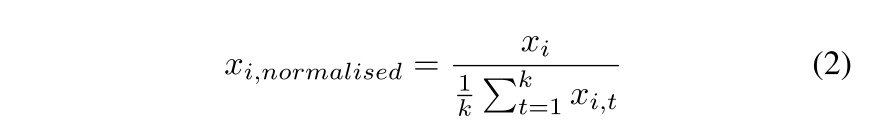

Simply collect a sum of the value, calculate the mean from the size of the array and divide every value by the mean in order to get a normalised value of it where the mean will return a value of 1. All of this is placed into a returned array, allowing for the function to then be called for every dataset.

1b) Time Series Pre-processing:

Variance Stabilization Layer : After normalizing the time series, they stabilize the variance in the group of time series by transforming each time series to a logarithmic scale. The transformation can be defined in the following way:
![image[1].png](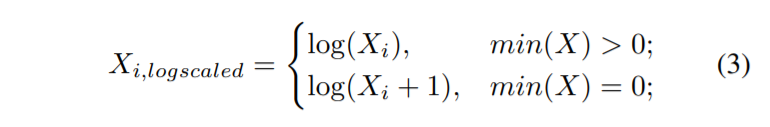)

1c) Time Series Pre-processing

Moving Window Transformation : As a preprocessing step, they transform the past observations of time series (Xi) into multiple pairs of input and output frames using a Moving Window (MW) strategy. In summary, the MW strategy converts a time series Xi of length K into (K − n − m) records, where each record has an amount of (m + n) observations. Here, m refers to the length of the output window (Forecast Period), and n is the length of the input window (Look back Period). These frames are generated according to the Multi-Input Multi-Output (MIMO) principle used in multi-step forecasting, which directly predicts all the future observations up to the intended forecasting horizon.

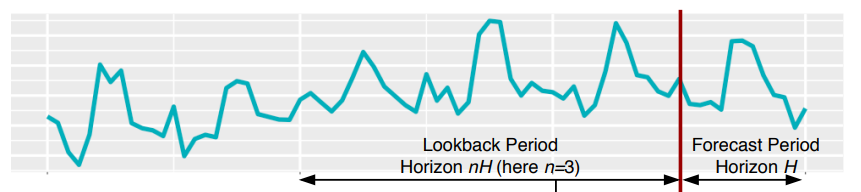

The input window or the Lookback Period = n* output window or Forecast Period, with n being 1.5 in the paper. A very good example for understanding MIMO is:

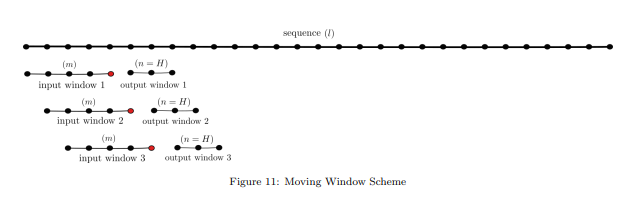

What we will do is create a function that takes in a dataset and trim it to the correct input ratio and have another function do the same for the output ratio.

In [ ]:
## PART 1 (30 points)
import math
import pandas as pd
import numpy as np
import torch

# establish dataframe
urlTrain = "https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/Test/Hourly-test.csv"
urlTest = "https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/Test/Hourly-test.csv"
dfHourlyTrain = pd.read_csv(urlTrain)
dfHourlyTest = pd.read_csv(urlTest)
dfHourlyTrain.dataframeName = 'Hourly-train.csv'
dfHourlyTest.dataframeName = 'Hourly-test.csv'
# dropping the first unnecessary column
dfHourlyTrain = dfHourlyTrain.drop(columns=['V1'])
dfHourlyTest = dfHourlyTest.drop(columns=['V1'])
#print(dfHourlyTrain)
#print(dfHourlyTest)



##--------Normalisation(10 points)--------
# normaliseXi normalises an array passed in by finding the mean then dividing every value in the array by that mean.
def normaliseXi(dataArray):
  sumXi = 0
  for entry in dataArray:
    sumXi += entry
  meanXi = 0
  meanXi = sumXi/(dataArray.size)
  normalisedArray = [0]*dataArray.size
  count = 0
  for entry in dataArray:
    normalisedArray[count] = torch.tensor(entry/meanXi)
    count += 1
  return normalisedArray

# testing tensor's training datasets with a successful response
normalisedTrainTSD = torch.empty([dfHourlyTrain.shape[1],dfHourlyTrain.shape[0]])
datasetCount = 0
for column in dfHourlyTrain:
  normalisedTrainTSD[datasetCount] = torch.stack(normaliseXi(dfHourlyTrain[column]))
  datasetCount += 1
#print(normalisedTSD)

# testing tensor's test datasets with a successful response
normalisedTestTSD = torch.empty([dfHourlyTrain.shape[1],dfHourlyTrain.shape[0]])
datasetCount = 0
for column in dfHourlyTrain:
  normalisedTestTSD[datasetCount] = torch.stack(normaliseXi(dfHourlyTrain[column]))
  datasetCount += 1
#print(normalisedTSD)



##--------Variance Stabilisation Layer (10 points)--------
# logScaledXi checks if the data's minimum value is equal to 0, if so it log scales every value as 1 greater, otherwise it just log scales the Xi value.
def logScaledXi(dataArray):
  logScaledArray = [0]*dataArray.size
  count = 0
  if min(dataArray) == 0:
    for entry in dataArray:
      logScaledArray[count] = torch.tensor(np.log(entry+1))
      count += 1
  else:
    for entry in dataArray:
      logScaledArray[count] = torch.tensor(np.log(entry))
      count += 1
  return logScaledArray

# testing tensor's training datasets with a successful response
logScaledTrainTSD = torch.empty([dfHourlyTrain.shape[1],dfHourlyTrain.shape[0]])
datasetCount = 0
for column in dfHourlyTrain:
  logScaledTrainTSD[datasetCount] = torch.stack(logScaledXi(dfHourlyTrain[column]))
  datasetCount += 1
#print(logScaledTSD)

# testing tensor's test datasets with a successful response
logScaledTestTSD = torch.empty([dfHourlyTest.shape[1],dfHourlyTrain.shape[0]])
datasetCount = 0
for column in dfHourlyTrain:
  logScaledTestTSD[datasetCount] = torch.stack(logScaledXi(dfHourlyTrain[column]))
  datasetCount += 1
#print(logScaledTSD)



##--------Moving Window Transformation (10 points)--------
# find input and output horizons for moving window
def findLookback(dataArray):
  inputSize = math.floor((3.0 * dataArray.size)/ 5.0)
  return dataArray[:inputSize]
  
def findForecast(dataArray): 
  forecastHorizon = math.ceil((2.0 * dataArray.size)/ 5.0)
  return dataArray[dataArray.size-forecastHorizon:]

# testing tensor's first dataset with a successful response
#print(logScaledTSD[0].size(0))
#print(findLookback(logScaledTSD[0]).size(0))
#print(findForecast(logScaledTSD[0]).size(0))



# 2)  Seasonal Decomposition

When modelling seasonal time series with NNs, many studies suggest applying a prior seasonal adjustment, i.e., de-seasonalization to the time series. The main intention of this approach is to minimize the complexity of the original time series by  detaching the multi-seasonal components from a time series, and thereby reducing the subsequent effort of the NN’s learning process. Here, Multi-seasonal components refer to the repeating patterns that exist in a time series and that may change slowly over time

The Author Proposes 5 Methods for Seasonal Decomposition :

- Multiple STL Decomposition (MSTL)

- Seasonal-Trend decomposition by Regression (STR)

- Trigonometric, Box-Cox, ARMA, Trend, Seasonal (TBATS)

- Prophet

- Fourier Transformation

It is required by the applicant to implement any one of the above mentioned techniques.

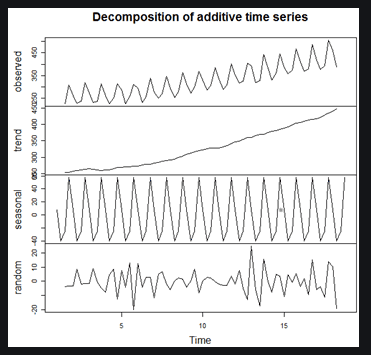

Step 2

# Step 2: Preprocessing (Part 2: Seasonal Decomposition)

## Introduction: Why do we decompose the algorithm?
Since we are attempting to predict how data will change over time, we are trying to optimise our neural network to fit an overall trend of the data and to do so accurately we do not want seasonal changes or randomness in the data series (residue) to affect the weights negatively as that would cause a less effective, less efficient and less optimised result.

## Multiple Seasonal and Trend Decompositions using Loess (MSTL)
MSTL uses Loess (Locally Estimated Scatterplot Smoothing) which uses k-nearest-neighbour and regression analysis techniques, taking a subset of data to create an average smooth trend line. This method can also be used to provide Residual and Seasonal components to the time series as well.

## Seasonal and Trend Decomposition by Regression (STR or STReg)
STR uses regression estimates of relationships between two variables to create a trend, seasonal data with a left over residue.

## Trigonometric, Box-Cox, AutoRegressive-Moving-Average (ARMA), Trend, Seasonal (TBATS)
TBATS has a combibation of techniques including trigonometric seasonality, box-cox transformation and ARIMA errors allowing for trend and seasonal componants to be extracted. To further add on, it allows for a non integer, non nested and/or large seasonal periods making this my current top choice for this seasonal decomposition phase.

## Prophet
Prophet is a Python package unlike the others which are available in the Forecast package for R. It has regression, seasonal utility and a notable ability to accommodate holiday days such as Christmas Eve adjusting calculations for it. The significant problem here is the system only works with a date and time in mind which we do not have in the data provided to us.

## Fourier Transformation
Fourier Transformation is the use of a mathimatical formula created by Joseph Fourier and defined as below: 

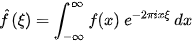

This formula represents the seasonality of the time series in the form of a wave, calculating an amplitude and frequency of this representative sin wave allowing us to remove it and decompose the time series data. 

## Which method of seasonal decomposition is best and why?
This is quite hard to decide, I'd personally want to decide based on the Mean Absolute Error (MAE) of the methodology on average. This is however very difficult to distinguish this without extensive lookup into the exact calculation of each system meaning to explore the Forecast package in R for each seperate method and calculate the MAE. As such, I decided to pick the method I found most interesting, that being TBATS.

If I had more time, I think it would be nice to calculate the MAE for each method similar to what is found in this [link.](https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a)

TBATS is installed using the following command line:

In [ ]:
pip install tbats

KeyboardInterrupt: ignored

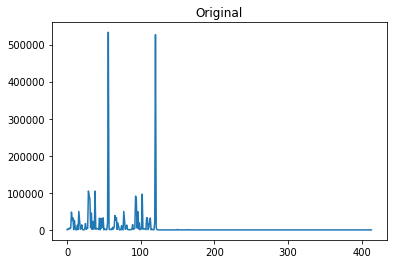

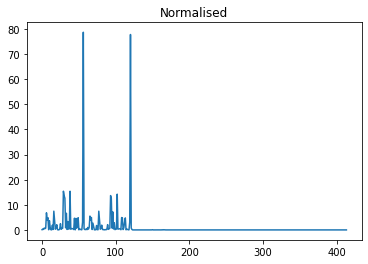

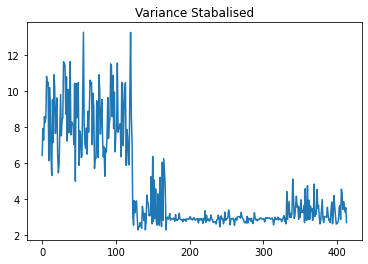

In [ ]:
## Part 2 (40 points)
##--------Seasonal Decomposition (use any one of the above mentioned 5 techniques) (TBATS) (20 points)--------

from tbats import BATS, TBATS
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting


# Plot original data
plt.figure(0)
plt.title('Original')
plt.plot(dfHourlyTrain['V3'])

plt.figure(1)
plt.title('Normalised')
plt.plot(normalisedTrainTSD[0])

plt.figure(2)
plt.title('Variance Stabalised')
plt.plot(logScaledTrainTSD[0])

# Create estimator
estimator = TBATS(seasonal_periods=[24, 168], use_trend=True,
                  # speeding up calculations
                  use_arma_errors=False,  # shall try only models without ARMA
                  use_box_cox=False  # will not use Box-Cox
                  )

# Fit model
prepTrainArray = torch.empty(logScaledTrainTSD.shape)
residTrainArray = torch.empty(logScaledTrainTSD.shape)
prepTestArray = torch.empty(logScaledTestTSD.shape)
residTestArray = torch.empty(logScaledTestTSD.shape)

# Show Data for Second Data Set
fitted_model = estimator.fit(logScaledTrainTSD[1])
fitted_model_test = estimator.fit(logScaledTestTSD[1])

prepTrain = torch.tensor(fitted_model.y_hat)
prepTest = torch.tensor(fitted_model_test.y_hat)




##--------Visualize working of the implemented Seasonal Decomposition technique by decomposing an Observed time series into its Trend, Seasonal and residual patterns (20 points)--------
# Display Post TBATS Information and Plots
print(fitted_model.summary())
plt.figure(3)
plt.title('TBATS Trend')
plt.plot(fitted_model.y_hat)
plt.figure(4)
plt.title('TBATS Residual')
plt.plot(fitted_model.resid)
count = 0
seasonalOut = [0]*logScaledTSD[0].size(0)
for entry in logScaledTSD[0]:
  seasonalOut[count] = logScaledTSD[0][count] - fitted_model.y_hat[count] - fitted_model.resid[count]

plt.figure(6)
plt.title('TBATS Seasonal Pattern')
print("Seasonal ", fitted_model.params.components.seasonal_harmonics)



# Warning for any problems, copied and pasted from the TBATS Detailed Example found here: https://github.com/intive-DataScience/tbats
for warning in fitted_model.warnings:
    print(warning)

print('Did the model fit?', fitted_model.is_fitted)  # Model may fail to fit in edge-case situations
print('AIC', fitted_model.aic)  # may be np.inf

# Lets check components used in the model
print('\n\nMODEL SUMMARY\n\n')
params = fitted_model.params
components = fitted_model.params.components

print('Smoothing parameter', params.alpha)

print('Seasonal periods',
          components.seasonal_periods)  # TBATS may choose non-seasonal model even if you provide seasons
print('Harmonics amount for each season', components.seasonal_harmonics)
print('1st seasonal smoothing parameters', params.gamma_1())  # one value for each season
print('2nd seasonal smoothing parameters', params.gamma_2())  # one value for each season

print('Trend and damping', components.use_trend, components.use_damped_trend)
print('Trend', params.beta)
print('Damping', params.phi)

print('Use Box-Cox', components.use_box_cox)
print('Box-Cox lambda interval that was considered', components.box_cox_bounds)
print('Box-Cox lambda', params.box_cox_lambda)

print('ARMA residuals modelling', components.use_arma_errors)
print('ARMA(p, q)', components.p, components.q)
print('AR parameters', params.ar_coefs)
print('MA parameters', params.ma_coefs)

print('Seed state', params.x0)

# Short model summary
print('\n\nSUMMARY FUNCTION\n\n')
print(fitted_model.summary())

print('\n\nIN SAMPLE PREDICTIONS\n\n')
print('Original time series (5 first values)', fitted_model.y[:5])
print('Predictions (5 first values)', fitted_model.y_hat[:5])
print('Residuals (5 first values)', fitted_model.resid[:5])

In [ ]:
## If you would like to comput TBATS for all data: (Warning: TAKES AGES)
counter = 0
for entry in normalisedTrainTSD:
  fitted_model = estimator.fit(logScaledTrainTSD[counter])
  prepTrainArray[counter] = torch.tensor(fitted_model.y_hat)
  residTrainArray[counter] = torch.tensor(fitted_model.resid)
  counter += 1

counter = 0
for entry in normalisedTestTSD:
  fitted_model = estimator.fit(logScaledTestTSD[counter])
  prepTestArray[counter] = torch.tensor(fitted_model.y_hat)
  residTestArray[counter] = torch.tensor(fitted_model.resid)
  counter += 1

3) Training Paradigms

The Author proposed two methods for training the LSTM model:
Deseasonalised Approach (DS): This approach uses seasonally adjusted time series as moving window patches to train the LSTM-MSNet. Since the seasonal components are not included in DS for the training procedure, a reseasonalisation technique is later introduced in the Post-processing layer of LSTM-MSNet to ascertain the corresponding multiple seasonal components of the time series.
Seasonal Exogenous Approach (SE): This second approach uses the output of the pre-processing layer, together with the seasonal components extracted from the multi-seasonal decomposition as external variables. Here, in addition to the normalized time series (without the deseasonalisation phase), the seasonal components relevant to the last observation of the input window are used as exogenous variables in each input window. As the original components of the time series are used in the training phase of SE, the LSTM-MSNet is expected to forecast all the components of a time series, including the relevant multi-seasonal patterns. Therefore, a reseasonalisation stage is not required by SE.

In summary, DS supplements the LSTM-MSNet by excluding the seasonal factors in the LSTM-MSNet training procedure. This essentially minimises the overall training complexity of the LSTM-MSNet. In contrast, SE supplements LSTM-MSNet in the form of exogenous variables that assist modelling the seasonal trajectories of a time series.

Fortunately , it is required by the applicant to just implement Deseasonalised Approach (DS), feel free to also implement Seasonal Exogenous Approach (SE), though its not a mandatory criteria.
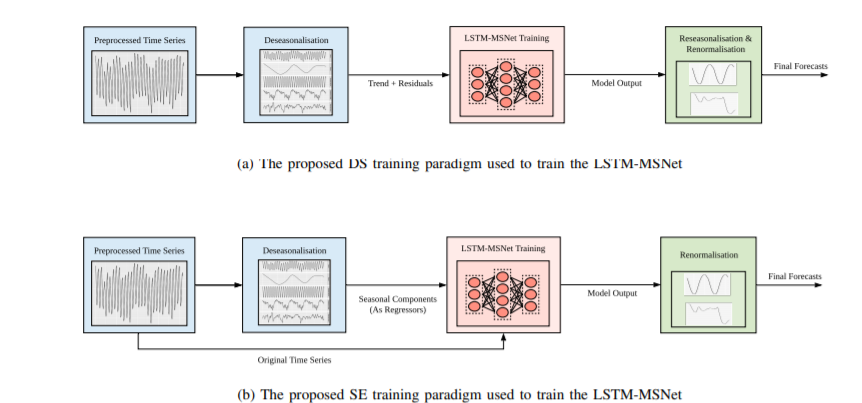

LSTM Learning Scheme
As highlighted earlier, the author uses the past observations of time series Xi , in the form of input and output windows to train the LSTM-MSNet. The author uses the LSTM model mentioned in this paper: https://arxiv.org/pdf/1909.00590.pdf, feel free to use any LSTM implementation as long as it is working in the right way.

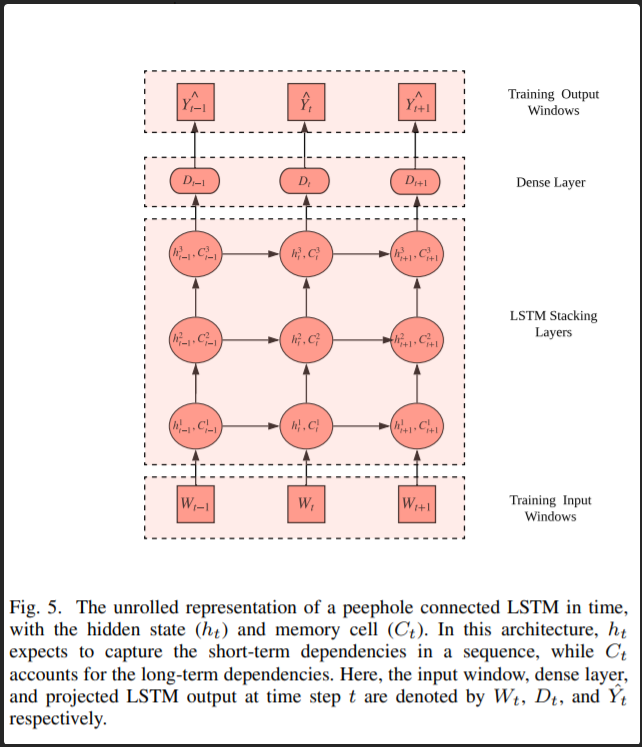

Loss Function

The author uses the L1-norm, as the primary learning objective function, which essentially minimizes the absolute differences between the target values and the estimated values. They also include an L2-regularization term to minimize possible over fitting of the network

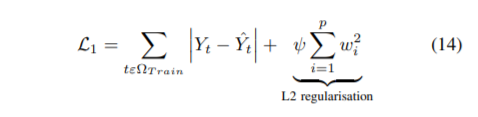



# Actually Coding an LSTM with Peephole Network
I will be using some handy diagrams I find on the internet and will reference to them as we go along with the links at the end.

To begin with we need to understand how a Recurrent Neural Network works so we can expand off of it. A recurrent neural network simply is a neural network that keeps a bit of memory from the last training session and uses it to influence the training of the current input via the Hidden State. We can see the general idea in this diagram: ![Gif of RNN](https://blog.floydhub.com/content/images/2019/06/ezgif.com-video-to-gif.gif)

This is a kind of memory albiet short making it significantly weak for things like Natural Language Processing. The example the Author in link 1 describes a system for guessing the last word in a sentence. Lets say we have 3 sentences: "I have a dog named Cliff", "I used to bring him to work" and "Unfortunately the sing says no ____". An RNN would use memory from the 2nd sentence when looking at the third and trying to guess. We, as humans, know the answer will be dogs but the RNN will only have memory of the second sentence and the first cannot inform the choice being made. To solve this we use Long Short Term Memory networks. The reason for this is because as well as a hidden state, we have a new attribute to the cell called a Cell State. This is a memory state that changes a lot less between different LSTM cells as it has more policing in what changes the data stored there as well as it moving from cell to cell in a sort of pipe line manner. This means that things like the subject of a sentence such as the dog in the previous example can be stored in the cell state to allow for its usage in the third sentence. 

Of course, since we're doing financial forecasting, we can apply this idea to our data by using general patterns in our trends to help us forecast more accurately. For example, using an RNN on its own, we run the risk of a small spike in inputs causing a jump in our outputs that continue and set a new inaccurate norm. To avoid this we need a much more long term solution to the problem and that's where LSTM comes in.

Now that we have the simple idea of how an LSTM works, let us look at the components of an individual LSTM cell [link 2]:

![LSTM Cell with Peepholes](https://www.researchgate.net/publication/301318916/figure/fig2/AS:362121620672514@1463347930162/Detailed-architecture-of-the-peephole-LSTM.png)

For now we shall ignore the peephole calculations (blue dotted lines) for they are not necessarily part of the default cell.
At the bottom, represented by X<sub>t</sub>, is the input going into the cell to process at time t. The left side has c<sub>t-1</sub> and h<sub>t-1</sub> which are the cell state and hidden state of the previous LSTM cell (iteration) of which this cell may or may not change based on relavence and eventually leads to c<sub>t</sub> and σ which is the outgoing cell states and hidden states at time t respectively. You can also see that the hidden state is copied with an arrow going up, that is the output of this LSTM Cell. 

Now that that is out of the way we can quickly go over the functions. The σ function is the sigmoid function which puts all values on a scale between 0 and 1, where the larger the value, the closer to 1 you get and vice verse, where 0 being put in the function yeilds 0.5. The tanh function is similuar but it places all values on a range of -1 to +1 with 0 yeilding 0 after the function. The symbols in the circles are defined in the Legend.

The remaining symbols are gates that allow the flow of information. Think of it like a filter allowing only certain useful bits in. The equations for these gates is defined by the following formulas: [Link 3]

![LSTM Formulas](https://wikimedia.org/api/rest_v1/media/math/render/svg/7dee414820d5c0162ae1fff1899e58b08923944f)

**f<sub>t</sub> is the forget gate.** This is defining what and how much information is being forgotten and as a value between 0 and 1, it will multiply itself with the cell state to create a removal of information. [Link 1]

![LSTM Forget Gate](https://blog.floydhub.com/content/images/2019/06/Slide21.JPG)

**i<sub>t</sub> is the input gate.** This determines what new information gets inputed into long term memory via being added to the cell state. [Link 1]

![LSTM Input Gate](https://blog.floydhub.com/content/images/2019/06/Slide20.JPG)


**o<sub>t</sub> is the output gate.** This creates a new hidden state thats being outputed as well as passed on to the next LSTM cell (iteration) using the cell state, the current input and the hidden state being given from the previous LSTM cell (iteration). [Link 1]

![LSTM Output Gate](https://blog.floydhub.com/content/images/2019/06/Slide22.JPG)


However, we will be using peepholes as they allow our gates to access the Constant Error Carousel (CEC) which simply means that what information is allowed is based on the previous cell state from the LSTM cell beforehand giving the calculations a peek before making a decision. To reflect this in our calculations we add c<sub>t-1</sub> to all of our gate and input calculations as follows: [Link 3]

![LSTM Formulas with Peephole Connection](https://wikimedia.org/api/rest_v1/media/math/render/svg/c989b6299ec9d1166cc09573bda543824237119d)

And finally, we have the framework from which to build the network for this project below.


Links:

1- https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/
2- https://www.researchgate.net/figure/Detailed-architecture-of-the-peephole-LSTM_fig2_301318916
3- https://en.wikipedia.org/wiki/Long_short-term_memory

In [ ]:
## PART 3 (50 points)
## Using the Deseasonalised Approach (DS) train a LSTM model with Post-Processing Layer(50 points)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import math
from tqdm.notebook import tqdm


# --Set Up Training--

# establish torch seed
torch.manual_seed(123456)

# establish dataframe
urlTrain = "https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/Test/Hourly-test.csv"
urlTest = "https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/Test/Hourly-test.csv"
dfHourlyTrain = pd.read_csv(urlTrain)
dfHourlyTest = pd.read_csv(urlTest)
dfHourlyTrain.dataframeName = 'Hourly-train.csv'
dfHourlyTest.dataframeName = 'Hourly-test.csv'
# dropping the first unnecessary column
dfHourlyTrain = dfHourlyTrain.drop(columns=['V1'])
dfHourlyTest = dfHourlyTest.drop(columns=['V1'])
#print(dfHourlyTrain)
#print(dfHourlyTest)

# find sizes of first data series #Remove Later
#totalSize = dfHourlyTrain['V2'].size #Remove Later
#inputSize = math.floor((3*totalSize)/5) #Remove Later
#orecastHorizon = math.ceil((2*totalSize)/5) #Remove Later

#print("T: " + str(totalSize) + " I: " + str(inputSize) + " H: " + str(forecastHorizon)) #Remove Later


inputSize = 15;
hiddenSize = 10;
LSTMLayers = 3;

batchSize = 1;
seqLen = 1;

## MSNet with Peepholes
class PeepLSTM(nn.Module):
    def __init__(self, inputSize, hiddenSize, peephole=False):
        super().__init__()
        self.inputSize = inputSize
        self.hidden_size = hiddenSize
        self.peephole = peephole
        self.W = nn.Parameter(torch.Tensor(inputSize, hiddenSize * 4))
        self.U = nn.Parameter(torch.Tensor(hiddenSize, hiddenSize * 4))
        self.bias = nn.Parameter(torch.Tensor(hiddenSize * 4))
        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x, init_states=None):
        """(batch, sequence, feature)"""
        bs, seqSize, _ = x.size()
        hiddenSeq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
         
        HS = self.hidden_size
        for t in range(seqSize):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            
            if self.peephole:
                gates = x_t @ self.U + c_t @ self.W + self.bias
            else:
                gates = x_t @ self.U + h_t @ self.W + self.bias
                g_t = torch.tanh(gates[:, HS*2:HS*3])
            
            i_t, f_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input gate
                torch.sigmoid(gates[:, HS:HS*2]), # forget gate
                torch.sigmoid(gates[:, HS*3:]), # output gate
            )
            
            if self.peephole:
                c_t = f_t * c_t + i_t * torch.sigmoid(x_t @ self.U + self.bias)[:, HS*2:HS*3]
                h_t = torch.tanh(o_t * c_t)
            else:
                c_t = f_t * c_t + i_t * g_t
                h_t = o_t * torch.tanh(c_t)
                
            hiddenSeq.append(h_t.unsqueeze(0))
            
        hiddenSeq = torch.cat(hiddenSeq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hiddenSeq = hiddenSeq.transpose(0, 1).contiguous()
        
        return hiddenSeq, (h_t, c_t)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(32, 32)
        self.lstm = PeepLSTM(32, 32, True) #input, hidden, peepholes=true
        self.fc1 = nn.Linear(32, 2)
        
    def forward(self, x):
        x_ = self.embedding(x)
        x_, (h_n, c_n) = self.lstm(x_)
        x_ = (x_[:, -1, :])
        x_ = self.fc1(x_)
        return x_

device = torch.device('cpu')
classifier = Net().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=0.005)#0.002 dives 85% acc
criterion = nn.L1Loss(reduction='sum') # stated in the paper's equation that the l1loss is a sum and not a mean
LSTM_MSNet = PeepLSTM(inputSize, hiddenSize, peephole=True)

## Define Training Data and Test Data
trainingInputs = torch.tensor(findLookback(prepTrain))
trainingOutputs = torch.tensor(findForecast(prepTrain))

testInputs = torch.tensor(findLookback(prepTest))
testOutputs = torch.tensor(findForecast(prepTest))

trainingDataset = torch.utils.data.TensorDataset(trainingInputs, trainingOutputs)
trainingLoader = torch.utils.data.DataLoader(trainingDataset, batch_size=128, shuffle=True)

testDataset = torch.utils.data.TensorDataset(testInputs, testOutputs)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=256, shuffle=True)



## Training the LSTM-MSNet
epoch_bar = tqdm(range(10), desc="Training", position=0, total=2)
acc = 0

for epoch in epoch_bar:
    batch_bar = tqdm(enumerate(trainingLoader),
                     desc="Epoch: {}".format(str(epoch)),
                     position=1,
                     total=len(trainingLoader))
  
    for i, (datapoints, labels) in batch_bar:
        
        optimizer.zero_grad()
        
        preds = classifier(datapoints.long())
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            acc = 0
            
            with torch.no_grad():
                for  i, (datapoints_, labels_) in enumerate(test_loader):
                    preds = classifier(datapoints_)
                    acc += (preds.argmax(dim=1) == labels_).float().sum().cpu().item()
            acc /= len(X_test)

        batch_bar.set_postfix(loss=loss.cpu().item(),
                              accuracy="{:.2f}".format(acc),
                              epoch=epoch)
        batch_bar.update()

        
    epoch_bar.set_postfix(loss=loss.cpu().item(),
                          accuracy="{:.2f}".format(acc),
                          epoch=epoch)
    epoch_bar.update()

AssertionError: ignored

Here we analyse how successful our network is using the Median and Mean of the following equations:

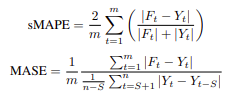

Since we will be getting multiple Arrays of arrays, we must first define each function and then get a mean and median of each function as such below:

In [ ]:
## Part 4 (40 points)
##Evaluate the model's performance on the following 4 error metrics using the test set(mentioned in About the Dataset):
import statistics
import numpy as np
from numpy import zeros
from sklearn.metrics import mean_absolute_error
import math

##mean of the sMAPEs (Mean sMAPE)
def sMAPE(actualArray, forecastArray):
  return 1/len(actualArray) * np.sum(2 * np.abs(forecastArray - actualArray) / (np.abs(actualArray) + np.abs(forecastArray)))

def meanSMAPE(actualArraysList, forecastArraysList):
  assert len(actualArraysList) == len(forecastArraysList)
  counter = 0
  sumSMAPE = 0
  n = len(actualArraysList)
  while counter < n:
    sumSMAPE += sMAPE(actualArraysList[counter], forecastArraysList[counter])
    counter += 1
  return sumSMAPE/n
    

##median of the sMAPEs (Median sMAPE)
def medianSMAPE(actualArraysList, forecastArraysList):
  assert len(actualArraysList) == len(forecastArraysList)
  if len(actualArraysList)%2 == 0:  #if the length of the array has a midway median
    med1 = int(len(actualArraysList)/2)-1
    med2 = med1+1
    lengthMedArray = len(actualArraysList[med1])
    medianActArray = zeros(lengthMedArray)
    medianForArray = zeros(lengthMedArray)
    counter = 0
    while counter < lengthMedArray:
      medianActArray[counter] = (actualArraysList[med1][counter] + actualArraysList[med2][counter])/2
      medianForArray[counter] = (forecastArraysList[med1][counter] + forecastArraysList[med2][counter])/2
      counter += 1
    return sMAPE(medianActArray, medianForArray)
  else:
    med = math.ceil(len(actualArraysList)/2)
    return sMAPE(actualArraysList[med], forecastArraysList[med])

##mean of the MASEs (Mean MASE)
def MASE(actualArray, forecastArray, seasonality = 1):
    return np.mean(np.abs(actualArray - forecastArray)) / np.mean(np.abs(actualArray[seasonality:] - actualArray[:-seasonality]))

def meanMASE(actualArraysList, forecastArraysList):
  assert len(actualArraysList) == len(forecastArraysList)
  counter = 0
  sumMASE = 0
  n = len(actualArraysList)
  while counter < n:
    sumMASE += MASE(actualArraysList[counter], forecastArraysList[counter])
    counter += 1
  return sumMASE/n

##median MASEs (Median MASE)
def medianMASE(actualArraysList, forecastArraysList):
  assert len(actualArraysList) == len(forecastArraysList)
  if len(actualArraysList)%2 == 0:  #if the length of the array has a midway median
    med1 = int(len(actualArraysList)/2)-1
    med2 = med1+1
    lengthMedArray = len(actualArraysList[med1])
    medianActArray = zeros(lengthMedArray)
    medianForArray = zeros(lengthMedArray)
    counter = 0
    while counter < lengthMedArray:
      medianActArray[counter] = (actualArraysList[med1][counter] + actualArraysList[med2][counter])/2
      medianForArray[counter] = (forecastArraysList[med1][counter] + forecastArraysList[med2][counter])/2
      counter += 1
    return MASE(medianActArray, medianForArray)
  else:
    med = math.ceil(len(actualArraysList)/2)
    return MASE(actualArraysList[med], forecastArraysList[med])


ac = np.array([[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15]])
fo = np.array([[3,4,5,6,7],[8,9,10,11,12],[13,14,15,16,17]])
ac2 = np.array([[1,2,3,4,5],[6,7,8,9,10]])
fo2 = np.array([[3,4,5,6,7],[8,9,10,11,12]])
print(meanSMAPE(ac, fo))
print(medianSMAPE(ac,fo))
print(medianSMAPE(ac2,fo2))
print(meanMASE(ac,fo))
print(medianMASE(ac,fo))

0.31743053243053243
0.14434065934065934
0.3235467800173683
2.0
2.0


What I've learnt from doing this project:
- Sequential Model-based Algorithm Configurations and how to use them
- A great deal about the language R and the Forecast package within it
- Parsing Arguments in Python but not how to use them in Google Colab
- "In PyTorch things are way more imperative and dynamic: you can define, change and execute nodes as you go, no special session interfaces or placeholders." - [Said Here](https://towardsdatascience.com/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)
- Type Casting for Functions in Python
- The vast array of different packages made for Python
- The structure of an LSTM network with peepholes.


Things I'd Improve if I had more time:
- Learning Decay Testing (Check if learning decay may help to get a more optimised result)
- Implemented the SE Approach
- Type Cast all my Functions as to stop any problems that may come with incorrect usage of any function
- Figure out how to get the Seasonal Trend out of the Seasonal Decomposition (Maybe Remove)

References to code I learnt from and partially used:
- LSTM-MSNet :: https://github.com/kasungayan/LSTMMSNet
- LSTM by Hand :: https://github.com/piEsposito/pytorch-lstm-by-hand

## A message to you, the examinar:

I have had so much fun working on this project, the amount of work put into this is far beyond what I've seen for any job and it's been challenging work. 
I do so hope that I get the position as this is all so fascinating to me, not only this but I'd love to get my hands on a working version of the LSTM network that I unfortunately was unable to fix. 

At my starting point, I had never used PyTorch, nor had any large stastical background, nor used Google Colab in any capacity, nor seen any of the ideas explored in the paper except for neural networks and that's what really inspired me. I feel at fault for not handing in a perfect result but I hope my understanding of the concept makes up for my lack of understanding in Pytorch as Pytorch knowledge can come with experience but wrapping your head around the concepts isn't the easiest for everyone.

**Please, if it is not too much trouble could you give me a copy of what would be a good implementation of the LSTM for this example would look like so I can see where I went wrong, any analysis or evaluation on top of my own would be great and I look forward to more work in this field!** 

This entire project has really just sparked my fascination once more that I hadn't had for the past couple months.

Finally, thank you for this chance to take part in this project and I hope I will work alongside you soon!

Sincerely,

Nicholas Salter

My Email: salternicholas@yahoo.com

My Phone: 07931159803

